# Digit Recognition Program
- In this jupyter notebook, we illustrate the use of VSA encoding to do MNIST recognition.
- We also provide notes about our investigation of changing parameters like binarization of the AM and/or the bundled encoded vectors, and even the variation in dimension size.
- This notebook is meant to be investigative of different techniques.

In [1]:
# Parameters
import os
import sys
import numpy as np

# Path directories
curr_dir = os.getcwd()
lib_path = curr_dir + "/../../lib"
extract_path = curr_dir + "/../../extract_data"
data_path = curr_dir + "/../../data"
dir_bin_data = data_path + "/mnist_bin"

# Appending other paths for libraries
sys.path.append(lib_path)
sys.path.append(extract_path)

import vsa
import figs
from extract_data_util import download_and_extract, split_data, read_data

## Data Extraction

In [2]:
url = "https://github.com/rgantonio/chronomatica/releases/download/mnist_dataset_v1.0/chronomatica_mnist_bin.tar.gz"

download_and_extract(
    url=url,
    out_dir=data_path,
    delete_archive=True,
)

# Set class list
class_list = [0,1,2,3,4,5,6,7,8,9]

# Read data
X_data = read_data(class_list, dir_bin_data)

# Train and test split
train_test_split = 0.6
train_valid_split = 0.75

X_train_set, X_test_set = split_data(X_data, class_list, split_percent=0.6)
X_train_set_src, X_valid_set = split_data(X_train_set, class_list, split_percent=0.75)

Extracting...
Deleted archive: chronomatica_mnist_bin.tar.gz
Extraction complete!


Splitting data: 100%|██████████| 10/10 [00:00<00:00, 542.53it/s]


## VSA Model
- You can find more info from the `./lib/vsa.py`
- For every application you need to make a dedicated encoder.
- Here, we use the generic permute encoding where we permute the hypervector if it was white. Mathematically:
$$ \mathcal{hv}_{\textrm{enc}} = \sum_{i=0}^{N_{\textrm{feat}}=784} \mathcal{hv}_{\textrm{pixel}}[i] \ll \textrm{pixel-val}[i] $$
- Where $\textrm{pixel-val}$ shifts if the pixel $i$ white or not.
- The end $\mathcal{hv}_{\textrm{enc}} $ can be binarized or maintained.

In [3]:
class digitVSA(vsa.ModelVSA):
    def encode(self, item_data):
        # Feature length
        item_len = len(item_data)
        # Threshold for binarization
        threshold = item_len // 2
        # Encode hypervector
        encoded_vec = np.zeros(self.hv_size,dtype=int)
        for i in range(item_len):
            if(item_data[i] == 0):
                encoded_vec += self.ortho_im[i]
            else:
                encoded_vec += vsa.hv_perm(self.ortho_im[i],1)
        # Binarization
        if self.binarize_encode:
            encoded_vec = vsa.binarize_hv(encoded_vec, threshold, self.hv_type)
        return encoded_vec


# Create the VSA model with target parameters
digit_model = digitVSA(
    hv_size = 1024,
    class_list = class_list,
)

# Add the following to binarize the encoded value
digit_model.binarize_encode = True
# Add the following to binarize the AM
digit_model.binarize_am = True

## Training
- Training the model is done per class because of the VSA capabilities

In [4]:
# Train the model
digit_model.train_model(X_train_set_src)

Training class 9: 100%|██████████| 2677/2677 [00:05<00:00, 520.03it/s]

Training complete!


## Retraining the Model
- Retraining the model is a useful mechanism to further increase accuracy by 2-5% more

In [5]:
# Retraining the model
digit_model.retrain_model(X_valid_set)

Retraining class 9: 100%|██████████| 892/892 [00:01<00:00, 454.89it/s]

Retraining complete!


# Testing the Model
- Testing the model uses the same encoding scheme used

In [6]:
# Test the model
digit_model.test_model(X_test_set)

Testing class 9: 100%|██████████| 2380/2380 [00:05<00:00, 452.82it/s]


0.7435309804575191

In [7]:
# Print some statistics
digit_model.print_model_stats()


-----------------
Model Statistics:
-----------------
HV Size: 1024
HV Type: bipolar
Number of Orthogonal IMs: 1024
Number of Continuous IMs: 21
Number of Classes: 10
Binarize Encode: True
Binarize AM: True
Class 0 Accuracy: 88.69%
Class 1 Accuracy: 95.48%
Class 2 Accuracy: 72.85%
Class 3 Accuracy: 70.88%
Class 4 Accuracy: 72.49%
Class 5 Accuracy: 56.27%
Class 6 Accuracy: 77.57%
Class 7 Accuracy: 76.26%
Class 8 Accuracy: 68.46%
Class 9 Accuracy: 60.13%
Overall Accuracy: 74.35%


## Interesting Trends
- One thing is for sure, if you work in non binarized results, you get the best accuracy.
- But you do get better accuracy with binarized encoding!
- **Therefore, from here we can assume that the AM needs to be integer valued to get the best results!**
- The data below was extracted by running the program. So it was done manually at first but other experiments will do this more automatically.

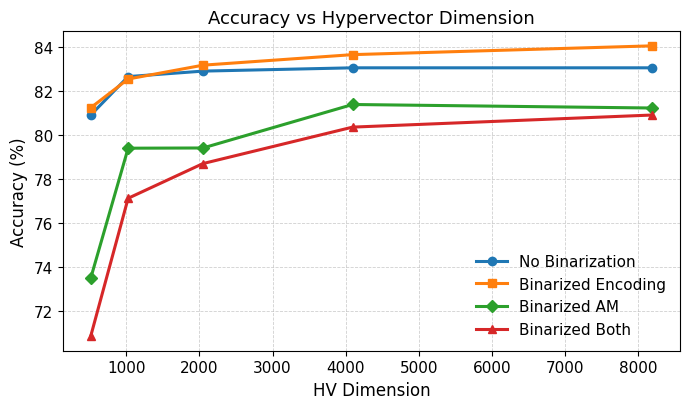

In [8]:
acc = [
    [80.90, 82.65, 82.90, 83.05, 83.05],
    [81.23, 82.54, 83.17, 83.65, 84.05],
    [73.47, 79.39, 79.40, 81.38, 81.22],
    [70.83, 77.11, 78.69, 80.35, 80.90]
]

hv_dim = [512, 1024, 2048, 4096, 8192]

legend = ['No Binarization', 'Binarized Encoding', 'Binarized AM', 'Binarized Both']
x_label = 'HV Dimension'
y_label = 'Accuracy (%)'
title = 'Accuracy vs Hypervector Dimension'

figs.multiLinePlot(
    x_data=hv_dim,
    y_data_list=acc,
    legend_list=legend,
    x_label=x_label,
    y_label=y_label,
    title=title,
).plot_fig()
